# 하려는 것
- Days_employed를 bin으로 나눠서 원핫인코딩

# Library

In [7]:
import warnings
warnings.filterwarnings('ignore')
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import random
import os

# Data Load & Preprocessing
- 훈련에 필요없는 index 컬럼 삭제.
- missing value를 모두 NAN 문자열로 대체
- dtype object 인 컬럼들을 onehot encoding

In [8]:
d = "C:\kaggle_data\credit_card"
lst = os.listdir(d)
print(lst)
train = pd.read_csv(d + '\\' +lst[3])
test = pd.read_csv(d + '\\' +lst[2])
ss = pd.read_csv(d + '\\' +lst[1])

['.ipynb_checkpoints', 'sample_submission.csv', 'test.csv', 'train.csv', 'Untitled.ipynb']


In [9]:
train = train.drop(['index'], axis=1)
train.fillna('NAN', inplace=True) 

test = test.drop(['index'], axis=1)
test.fillna('NAN', inplace=True)

In [10]:
# 연소로 바꿈
train['DAYS_EMPLOYED']=train['DAYS_EMPLOYED']/365
train['DAYS_EMPLOYED'] = abs(train['DAYS_EMPLOYED'])
train.loc[train['DAYS_EMPLOYED']>=36540,'DAYS_EMPLOYED']=-1

test['DAYS_EMPLOYED']=test['DAYS_EMPLOYED']/365
test['DAYS_EMPLOYED'] = abs(test['DAYS_EMPLOYED'])
test.loc[test['DAYS_EMPLOYED']>=36540,'DAYS_EMPLOYED']=-1

In [11]:
bin_edges = [-float('inf'),0,5,10,15,20,25,30,35,float('inf')]
train['work_bin'] = pd.cut(train['DAYS_EMPLOYED'],bin_edges,labels=False).astype('str')
test['work_bin'] = pd.cut(test['DAYS_EMPLOYED'],bin_edges,labels=False).astype('str')

<AxesSubplot:xlabel='work_bin', ylabel='Density'>

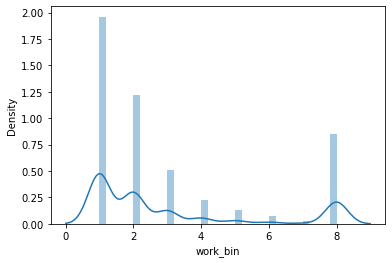

In [13]:
sns.distplot(train['work_bin'])

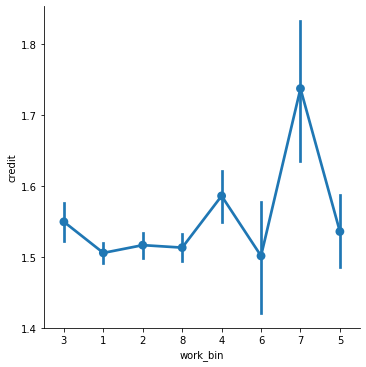

In [14]:
sns.factorplot(x='work_bin',y='credit',data=train)

In [7]:
train['log_income'] = np.log(train['income_total'])
test['log_income'] = np.log(test['income_total'])
train=train.drop('income_total',1)
test=test.drop('income_total',1)

In [116]:
train_days = train.drop('work_bin',1)
test_days = test.drop('work_bin',1)

train_bins = train.drop('DAYS_EMPLOYED',1)
test_bins = test.drop('DAYS_EMPLOYED',1)

In [117]:
days_col = []
for col in train_days:
    if train[col].dtype == 'object':
        days_col.append(col)
        
bins_col = []
for col in train_bins:
    if train[col].dtype == 'object':
        bins_col.append(col)        

In [118]:
def one_hot(train, test,object_col):
    total = pd.concat([train,test])
    enc = OneHotEncoder()
    enc.fit(total.loc[:,object_col])


    train_onehot_df = pd.DataFrame(enc.transform(train.loc[:,object_col]).toarray(), 
                 columns=enc.get_feature_names(object_col))
    train.drop(object_col, axis=1, inplace=True)
    train = pd.concat([train, train_onehot_df], axis=1)
    test_onehot_df = pd.DataFrame(enc.transform(test.loc[:,object_col]).toarray(), 
                 columns=enc.get_feature_names(object_col))
    test.drop(object_col, axis=1, inplace=True)
    test = pd.concat([test, test_onehot_df], axis=1)
    
    return train, test

In [119]:
train_days, test_days = one_hot(train_days, test_days,days_col)
train_bins, test_bins = one_hot(train_bins, test_bins,bins_col)

- ㅇAYS_BIRTH : 출생일, 데이터 수집일이 0이고 역으로 계산, int
- DAYS_EMPLOYED: 업무 시작일, 데이터 수집일이 0이고 역으로 계산, int
- begin_month: 신용카드 발급 월, 수집 당시 0 역으로 계산,int형

# 일 -> 연도로 바꿔보면
for c in ['DAYS_BIRTH','DAYS_EMPLOYED']:
    train[c] = (train[c]/12)
    test[c] = (test[c]/12)

# Training
- 데이터 분리는 StratifiedKFold 를 사용하여 y값 분포를 비슷하게 분리시킴. -> 5-fold
- lightgbm의 default parameter로 훈련.
- 30번 이상 개선 없을 경우 중단.
- 각 5개의 fold를 훈련하여 저장

In [ ]:
# train_days

In [120]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds=[]
for train_idx, valid_idx in skf.split(train_days.drop(['credit'],axis=1), train['credit']):
    folds.append((train_idx, valid_idx))

In [121]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds=[]
for train_idx, valid_idx in skf.split(train_days, train['credit']):
    folds.append((train_idx, valid_idx))
random.seed(42)
lgb_models={}
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = train_days.drop(['credit'],axis=1).iloc[train_idx].values, train_days.drop(['credit'],axis=1).iloc[valid_idx].values,\
                                         train['credit'][train_idx].values, train['credit'][valid_idx].values 
    lgb = LGBMClassifier(n_estimators=1000)
    lgb.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], 
            early_stopping_rounds=30,
           verbose=100)
    lgb_models[fold]=lgb
    print(f'================================================================================\n\n')

====================================1============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.650537	valid_1's multi_logloss: 0.752048
[200]	training's multi_logloss: 0.567573	valid_1's multi_logloss: 0.739493
[300]	training's multi_logloss: 0.50357	valid_1's multi_logloss: 0.734522
Early stopping, best iteration is:
[357]	training's multi_logloss: 0.472971	valid_1's multi_logloss: 0.731964


====================================2============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.651799	valid_1's multi_logloss: 0.766551
[200]	training's multi_logloss: 0.56397	valid_1's multi_logloss: 0.754866
[300]	training's multi_logloss: 0.499338	valid_1's multi_logloss: 0.750941
Early stopping, best iteration is:
[279]	training's multi_logloss: 0.511178	valid_1's multi_logloss: 0.749911


====================================3=====

In [123]:
ss.iloc[:,1:]=0
for fold in range(5):
    ss.iloc[:,1:] += lgb_models[fold].predict_proba(test_days)/5
ss.to_csv('train_days.csv', index=False) # 0.7272812144

In [124]:
from sklearn.model_selection import cross_val_score

print(cross_val_score(lgb_models[0], train_days.drop(['credit'],axis=1), train['credit'], cv=skf).mean())

0.7055977770263485


In [ ]:
# train bins

In [125]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds=[]
for train_idx, valid_idx in skf.split(train_bins, train['credit']):
    folds.append((train_idx, valid_idx))

In [126]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds=[]
for train_idx, valid_idx in skf.split(train_bins, train['credit']):
    folds.append((train_idx, valid_idx))
random.seed(42)
lgb_models={}
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = train_bins.drop(['credit'],axis=1).iloc[train_idx].values, train_bins.drop(['credit'],axis=1).iloc[valid_idx].values,\
                                         train['credit'][train_idx].values, train['credit'][valid_idx].values 
    lgb = LGBMClassifier(n_estimators=1000)
    lgb.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], 
            early_stopping_rounds=30,
           verbose=100)
    lgb_models[fold]=lgb
    print(f'================================================================================\n\n')

====================================1============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.662238	valid_1's multi_logloss: 0.761033
[200]	training's multi_logloss: 0.580071	valid_1's multi_logloss: 0.745568
[300]	training's multi_logloss: 0.518463	valid_1's multi_logloss: 0.741658
[400]	training's multi_logloss: 0.468028	valid_1's multi_logloss: 0.741175
Early stopping, best iteration is:
[376]	training's multi_logloss: 0.4795	valid_1's multi_logloss: 0.740915


====================================2============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.663577	valid_1's multi_logloss: 0.771239
[200]	training's multi_logloss: 0.578968	valid_1's multi_logloss: 0.755389
Early stopping, best iteration is:
[266]	training's multi_logloss: 0.535133	valid_1's multi_logloss: 0.751555


====================================3=====

In [127]:
from sklearn.model_selection import cross_val_score

print(cross_val_score(lgb_models[0], train_bins.drop(['credit'],axis=1), train['credit'], cv=skf).mean())

0.702271495128638


In [128]:
ss.iloc[:,1:]=0
for fold in range(5):
    ss.iloc[:,1:] += lgb_models[fold].predict_proba(test_bins)/5
ss.to_csv('train_bins.csv', index=False) # 0.7272812144

# Test inference
- 각 fold를 훈련시킨 lightgbm model로 predict.
- 해당 대회는 logloss score를 겨루는 것이기 때문에 각 class의 probability를 얻어야함.
- 대부분의 머신러닝 모델에서 predict, predict_proba를 구분하여 사용함.
- predict는 class 출력을 해주고 predict_proba는 class별 probability를 출력해줌.
- predict_proba를 사용하여 예측한 것을 5-fold 더하여 평균내어 앙상블.

In [10]:
ss.iloc[:,1:]=0
for fold in range(5):
    ss.iloc[:,1:] += lgb_models[fold].predict_proba(test)/5
ss.to_csv('add_BS.csv', index=False) # 0.7272812144

In [74]:
from sklearn.model_selection import cross_val_score

print(cross_val_score(lgb_models[0], train.drop(['credit'],axis=1), train['credit'], cv=skf).mean())

0.7060512846227132


In [12]:
ss.to_csv('add_BS.csv', index=False) # 0.7272812144

In [78]:
# cate, 직접 계산, 함수계산(동일), 다른 train계산 
days = ['days',0.7371671999999999, 0.7060512846227132, 0.7065426065426065,0]
bins = ['bins', 0.7459903999999999, 0.7082057939200797, 0.7032542175399319,0]

In [79]:
pd.DataFrame([days, bins], columns=['cate', '직접 계산', '함수계산(동일)', '다른 train계산','리더보드'])

,cate,직접 계산,함수계산(동일),다른 train계산,리더보드
0,days,0.737167,0.706051,0.706543,0
1,bins,0.745990,0.708206,0.703254,0
